# Fix pathing

In [1]:
import sys


sys.path.append("..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))


# Imports

In [3]:
import datahandler

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Incidents

In [4]:
data_preprocessor = datahandler.DataPreprocessorOUS_V2()
data_preprocessor.execute()

data_loader = datahandler.DataLoader(datahandler.DataPreprocessorOUS_V2)
data_loader.execute(clean=True, processed=True, enhanced=True)

Loading dataset: 100%|██████████| 6/6 [00:15<00:00,  2.56s/it]


In [5]:
df = data_loader.enhanced_incidents_df

# Response Time Histograms

In [6]:
data = pd.read_csv('./metrics/metrics_2024-04-10_12-33-22.csv')

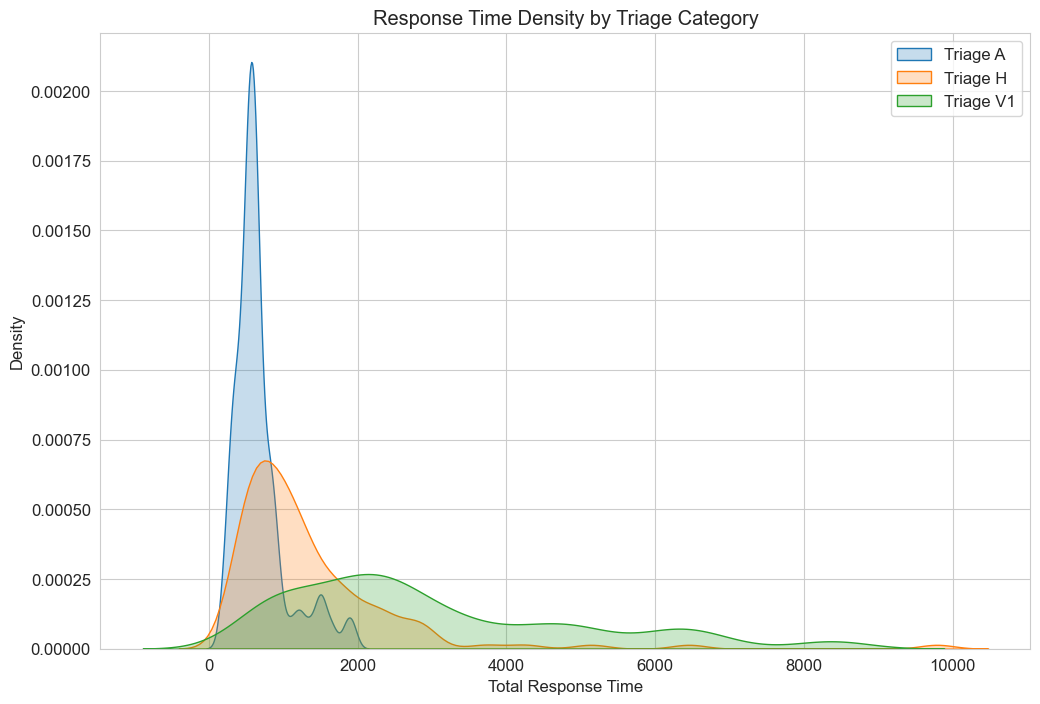

C:\Users\torju\AppData\Local\Temp\ipykernel_24616\1184678835.py:26: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(subset['total_response_time'], bw_adjust=0.5, label=f'Triage {triage_category}, Urban {urban}', fill=True)


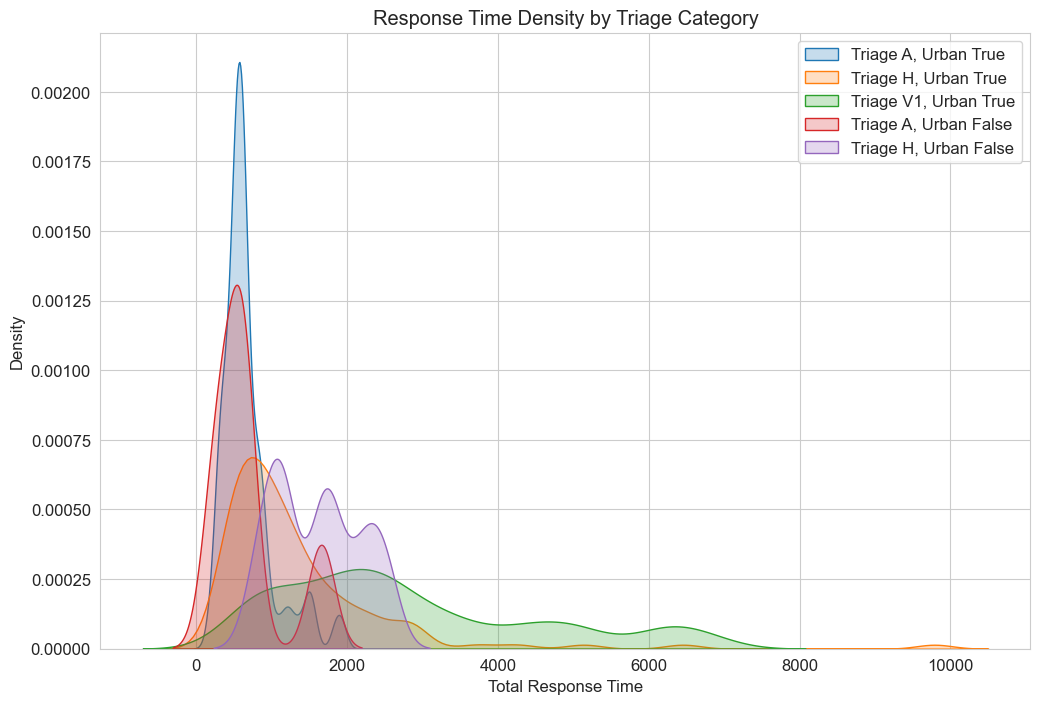

In [21]:
response_time_cols = ['duration_incident_creation', 'duration_resource_appointment',
                      'duration_resource_preparing_departure', 'duration_dispatching_to_scene']
data['total_response_time'] = data[response_time_cols].sum(axis=1)

plt.figure(figsize=(12, 8))

for triage_category in data['triage_impression_during_call'].unique():
    subset = data[data['triage_impression_during_call'] == triage_category]
    sns.kdeplot(subset['total_response_time'], bw_adjust=0.5, label=f'Triage {triage_category}', fill=True)

plt.title('Response Time Density by Triage Category')
plt.xlabel('Total Response Time')
plt.ylabel('Density')
plt.legend()
plt.show()

response_time_cols = ['duration_incident_creation', 'duration_resource_appointment',
                      'duration_resource_preparing_departure', 'duration_dispatching_to_scene']
data['total_response_time'] = data[response_time_cols].sum(axis=1)

plt.figure(figsize=(12, 8))

for urban in [True, False]:
    for triage_category in data['triage_impression_during_call'].unique():
        subset = data[(data['triage_impression_during_call'] == triage_category) & (data['urban'] == urban)]
        sns.kdeplot(subset['total_response_time'], bw_adjust=0.5, label=f'Triage {triage_category}, Urban {urban}', fill=True)
        
plt.title('Response Time Density by Triage Category and Urbanness')
plt.xlabel('Total Response Time')
plt.ylabel('Density')
plt.legend()
plt.show()



# Mean and Median

In [11]:
stats = data.groupby(['triage_impression_during_call', 'urban'])['total_response_time'].agg(['mean', 'median']).reset_index()

stats['mean'] = stats['mean'] / 60
stats['median'] = stats['median'] / 60

stats['urban'] = stats['urban'].map({True: 'Urban', False: 'Non-Urban'})

stats

,triage_impression_during_call,urban,mean,median
0,A,Non-Urban,11.236111,9.591667
1,A,Urban,11.142616,9.683333
2,H,Non-Urban,26.771429,28.133333
3,H,Urban,22.484454,16.583333
4,V1,Non-Urban,139.533333,139.533333
5,V1,Urban,46.859770,39.933333


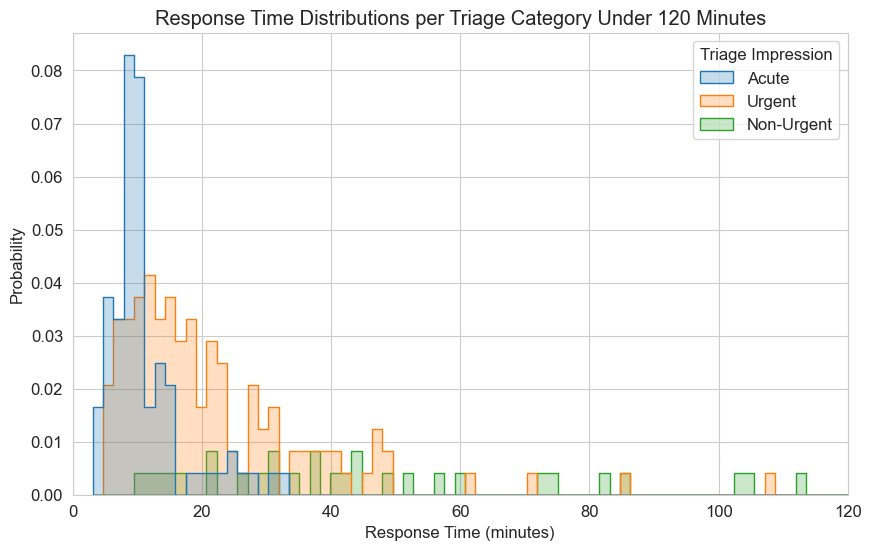

In [9]:
data['total_response_time_minutes'] = data['total_response_time'] / 60

category_mapping = {
    'A': 'Acute',
    'H': 'Urgent',
    'V1': 'Non-Urgent'
}

data['Triage Impression'] = data['triage_impression_during_call'].map(category_mapping)

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

hist_plot = sns.histplot(
    data=data,
    x='total_response_time_minutes',  # Updated to use minutes
    hue='Triage Impression',
    element="step",
    stat="probability",
    common_norm=True,
    palette="tab10",
    bins=100

plt.title('Response Time Distributions per Triage Category Under 120 Minutes')
plt.xlabel('Response Time (minutes)')
plt.ylabel('Probability')
plt.xlim(left=0, right=120)

plt.show()
